In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt
from zimmer.observations import HierarchicalAutoRegressiveObservations,  HierarchicalRobustAutoRegressiveObservations
from zimmer.transitions import HierarchicalStationaryTransitions, HierarchicalRecurrentTransitions, HierarchicalRBFRecurrentTransitions, HierarchicalRecurrentOnlyTransitions, HierarchicalNeuralNetworkRecurrentTransitions
from zimmer.util import cached

from ssm.models import HMM
from ssm.core import _HMM
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import RecurrentTransitions, InputDrivenTransitions, StationaryTransitions, \
    NeuralNetworkRecurrentTransitions, RecurrentOnlyTransitions, RBFRecurrentTransitions
from ssm.observations import IndependentAutoRegressiveObservations

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

from pyhsmm.util.general import relabel_by_permutation

In [2]:
# Specify hyperparameters
D = 10   # dimensionality of continuous latent states
M = 0   # dimensionality of input
results_dir = "results/kato/2018-11-28/D{}".format(D)

In [3]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]


K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


In [4]:
zimmer_perm = np.array([0, 1, 3, 2, 4, 5, 6, 7])
z_trues = [relabel_by_permutation(ztr, np.argsort(zimmer_perm)) for ztr in z_trues]
z_true_key = np.array(z_true_key)[zimmer_perm]

# Dimensionality reduction on $\Delta$F/F 

In [5]:
# Run PCA to get a 3d projection of the data
from ssm.preprocessing import pca_with_imputation
_pca = cached(results_dir, "pca")(pca_with_imputation)
pca, xs = _pca(D, ys, ms)
xs = [x.copy('C') for x in xs]

lim = 1.1 * abs(np.vstack(xs)).max()

In [6]:
def split_train_test(seed=0):
    np.random.seed(seed)

    chunk = 250
    train_frac = 0.7
    val_frac = 0.15
    all_ys = []
    all_xs = []
    all_ms = []
    all_tags = []
    all_z_trues = []
    all_choices = []
    for tag, (y, x, m, ztr) in enumerate(zip(ys, xs, ms, z_trues)):
        T = y.shape[0]
        C = 0
        for start in range(0, T, chunk):
            stop = min(start+chunk, T)
            all_ys.append(y[start:stop])
            all_xs.append(x[start:stop].copy('C'))
            all_ms.append(m[start:stop])
            all_z_trues.append(ztr[start:stop])
            all_tags.append(tag)
            C += 1

        # assign some of the data to train, val, and test
        choices = -1 * np.ones(C)
        choices[:int(train_frac * C)] = 0
        choices[int(train_frac * C):int((train_frac + val_frac) * C)] = 1
        choices[int((train_frac + val_frac) * C):] = 2
        choices = choices[np.random.permutation(C)]
        all_choices.append(choices)

    all_choices = np.concatenate(all_choices)
    get = lambda arr, chc: [x for x, c in zip(arr, all_choices) if c == chc]

    train_ys = get(all_ys, 0)
    train_xs = get(all_xs, 0)
    train_ms = get(all_ms, 0)
    train_zs = get(all_z_trues, 0)
    train_tags = get(all_tags, 0)

    val_ys = get(all_ys, 1)
    val_xs = get(all_xs, 1)
    val_ms = get(all_ms, 1)
    val_zs = get(all_z_trues, 1)
    val_tags = get(all_tags, 1)

    test_ys = get(all_ys, 2)
    test_xs = get(all_xs, 2)
    test_ms = get(all_ms, 2)
    test_zs = get(all_z_trues, 2)
    test_tags = get(all_tags, 2)
    
    return (train_ys, train_xs, train_ms, train_zs, train_tags), \
           (val_ys, val_xs, val_ms, val_zs, val_tags), \
           (test_ys, test_xs, test_ms, test_zs, test_tags)
        
_split = cached(results_dir, "split_train_test")(split_train_test)
train, val, test = _split()
train_ys, train_xs, train_ms, train_zs, train_tags = train
val_ys, val_xs, val_ms, val_zs, val_tags = val
test_ys, test_xs, test_ms, test_zs, test_tags = test

In [7]:
print("Training chunks per worm:   ", np.bincount(train_tags))
print("Validation chunks per worm: ", np.bincount(val_tags))
print("Testing chunks per worm:    ", np.bincount(test_tags))

Training chunks per worm:    [9 9 9 9 9]
Validation chunks per worm:  [2 2 2 2 2]
Testing chunks per worm:     [2 2 2 2 2]


In [8]:
# Compute number of training, validation, and test entries
D_train = sum([x.size for x in train_xs])
D_val = sum([x.size for x in val_xs])
D_test = sum([x.size for x in test_xs])

print("D_train: ", D_train)
print("D_val:   ", D_val)
print("D_test:  ", D_test)

D_train:  112070
D_val:    25000
D_test:   24890


# Fit an ARHMM to the continuous latent states, sweeping over number of discrete latent states

In [13]:
Ks = np.arange(2, 21, step=2)
transitionss = ["standard", "recurrent", "rbf_recurrent"]
observationss = ["ar", "robust_ar"]
etas = [1e8, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]

In [14]:
def _fit_hmm(K, transitions, observations):
    hmm = HMM(K, D, M, transitions=transitions, observations=observations)
    lps = hmm.fit(train_xs, method="em", num_em_iters=250)
    val_ll = hmm.log_likelihood(val_xs)
    return hmm, lps, val_ll

In [ ]:
hmm_results = {}
for K in Ks:
    for transitions in transitionss:
        for observations in observationss:
            hmm_results_name = "hmm_{}_{}_K{}".format(transitions, observations, K)
            fit = cached(results_dir, hmm_results_name)(_fit_hmm)
            
            print("Fitting ", hmm_results_name)
            hmm_results[hmm_results_name] = fit(K, transitions, observations)
            
with open(os.path.join(results_dir, "hmm_results.pkl"), "wb") as f:
    pickle.dump(hmm_results, f)

Fitting  hmm_standard_ar_K2
Fitting  hmm_standard_robust_ar_K2
Fitting  hmm_recurrent_ar_K2
Fitting  hmm_recurrent_robust_ar_K2
Fitting  hmm_rbf_recurrent_ar_K2


A Jupyter Widget

/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Fitting  hmm_rbf_recurrent_robust_ar_K2


A Jupyter Widget

/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Fitting  hmm_standard_ar_K4
Fitting  hmm_standard_robust_ar_K4
Fitting  hmm_recurrent_ar_K4
Fitting  hmm_recurrent_robust_ar_K4
Fitting  hmm_rbf_recurrent_ar_K4


A Jupyter Widget

/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Fitting  hmm_rbf_recurrent_robust_ar_K4


A Jupyter Widget

/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Fitting  hmm_standard_ar_K6
Fitting  hmm_standard_robust_ar_K6
Fitting  hmm_recurrent_ar_K6
Fitting  hmm_recurrent_robust_ar_K6
Fitting  hmm_rbf_recurrent_ar_K6


A Jupyter Widget

/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Fitting  hmm_rbf_recurrent_robust_ar_K6


A Jupyter Widget

/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/scott/Projects/ssm/ssm/util.py:189: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [0.001,20].
  "bounds [{},{}].".format(nu_min, nu_max))


Fitting  hmm_standard_ar_K8
Fitting  hmm_standard_robust_ar_K8
Fitting  hmm_recurrent_ar_K8
Fitting  hmm_recurrent_robust_ar_K8
Fitting  hmm_rbf_recurrent_ar_K8


A Jupyter Widget

/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Fitting  hmm_rbf_recurrent_robust_ar_K8


A Jupyter Widget

/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/scott/Projects/ssm/ssm/util.py:189: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [0.001,20].
  "bounds [{},{}].".format(nu_min, nu_max))


Fitting  hmm_standard_ar_K10
Fitting  hmm_standard_robust_ar_K10
Fitting  hmm_recurrent_ar_K10
Fitting  hmm_recurrent_robust_ar_K10
Fitting  hmm_rbf_recurrent_ar_K10


A Jupyter Widget

/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Fitting  hmm_rbf_recurrent_robust_ar_K10


A Jupyter Widget

/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/scott/Projects/ssm/ssm/util.py:189: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [0.001,20].
  "bounds [{},{}].".format(nu_min, nu_max))


Fitting  hmm_standard_ar_K12
Fitting  hmm_standard_robust_ar_K12
Fitting  hmm_recurrent_ar_K12
Fitting  hmm_recurrent_robust_ar_K12
Fitting  hmm_rbf_recurrent_ar_K12


A Jupyter Widget

/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Fitting  hmm_rbf_recurrent_robust_ar_K12


A Jupyter Widget

/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/scott/Projects/ssm/ssm/util.py:189: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [0.001,20].
  "bounds [{},{}].".format(nu_min, nu_max))


Fitting  hmm_standard_ar_K14
Fitting  hmm_standard_robust_ar_K14
Fitting  hmm_recurrent_ar_K14
Fitting  hmm_recurrent_robust_ar_K14
Fitting  hmm_rbf_recurrent_ar_K14


A Jupyter Widget

/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Fitting  hmm_rbf_recurrent_robust_ar_K14


A Jupyter Widget

/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/scott/Projects/ssm/ssm/util.py:189: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [0.001,20].
  "bounds [{},{}].".format(nu_min, nu_max))


# Fit hierarchical HMMs

In [12]:
def _fit_hierarchical_hmm(K, transitions, observations, hmm, eta):
    # Construct the HMM components
    init_state_distn = InitialStateDistribution(K, D, M)

    transition_classes = dict(standard=HierarchicalStationaryTransitions,
                              recurrent=HierarchicalRecurrentTransitions,
                              rbf_recurrent=HierarchicalRBFRecurrentTransitions)
    transition_distn = transition_classes[transitions](K, D, M=M, tags=tuple(range(W)), eta=eta)
    
    observation_classes = dict(ar=HierarchicalAutoRegressiveObservations, 
                               robust_ar=HierarchicalRobustAutoRegressiveObservations)
    observation_distn = observation_classes[observations](K, D, M=M, tags=tuple(range(W)), eta=eta)
    
    # Construct the HMM
    hhmm = _HMM(K, D, M, init_state_distn, transition_distn, observation_distn)

    # Initialize with the standard HMM
    hhmm.init_state_distn.params = copy.deepcopy(hmm.init_state_distn.params)
    hhmm.transitions.initialize_from_standard(hmm.transitions)
    hhmm.observations.initialize_from_standard(hmm.observations)

    # Fit
    lps = hhmm.fit(train_xs, tags=train_tags, method="em", num_em_iters=100, initialize=False)
    
    # Validate
    val_ll = hhmm.log_likelihood(val_xs, tags=val_tags)
    return hhmm, lps, val_ll

In [13]:
hhmm_results = {}
for K in Ks:
    for eta in etas:
        for transitions in transitionss:
            for observations in observationss:
                # Get the HMM results
                hmm_results_name = "hmm_{}_{}_K{}".format(transitions, observations, K)
                hmm, _, _ = hmm_results[hmm_results_name]

                # Fit the Hierarchical HMM
                hhmm_results_name = "hhmm_{}_{}_K{}_eta{:1.0e}".format(transitions, observations, K, eta)
                fit = cached(results_dir, hhmm_results_name)(_fit_hierarchical_hmm)
                print("Fitting ", hhmm_results_name)
                hhmm_results[hhmm_results_name] = fit(K, transitions, observations, hmm, eta)
            
with open(os.path.join(results_dir, "hhmm_results.pkl"), "wb") as f:
    pickle.dump(hhmm_results, f)

Fitting  hhmm_standard_ar_K2_eta1e+08
Fitting  hhmm_standard_robust_ar_K2_eta1e+08
Fitting  hhmm_recurrent_ar_K2_eta1e+08
Fitting  hhmm_recurrent_robust_ar_K2_eta1e+08
Fitting  hhmm_standard_ar_K2_eta1e+00
Fitting  hhmm_standard_robust_ar_K2_eta1e+00
Fitting  hhmm_recurrent_ar_K2_eta1e+00
Fitting  hhmm_recurrent_robust_ar_K2_eta1e+00
Fitting  hhmm_standard_ar_K2_eta1e-01
Fitting  hhmm_standard_robust_ar_K2_eta1e-01
Fitting  hhmm_recurrent_ar_K2_eta1e-01
Fitting  hhmm_recurrent_robust_ar_K2_eta1e-01
Fitting  hhmm_standard_ar_K2_eta1e-02
Fitting  hhmm_standard_robust_ar_K2_eta1e-02
Fitting  hhmm_recurrent_ar_K2_eta1e-02
Fitting  hhmm_recurrent_robust_ar_K2_eta1e-02
Fitting  hhmm_standard_ar_K2_eta1e-03
Fitting  hhmm_standard_robust_ar_K2_eta1e-03
Fitting  hhmm_recurrent_ar_K2_eta1e-03
Fitting  hhmm_recurrent_robust_ar_K2_eta1e-03
Fitting  hhmm_standard_ar_K2_eta1e-04
Fitting  hhmm_standard_robust_ar_K2_eta1e-04
Fitting  hhmm_recurrent_ar_K2_eta1e-04
Fitting  hhmm_recurrent_robust_ar_K2_e

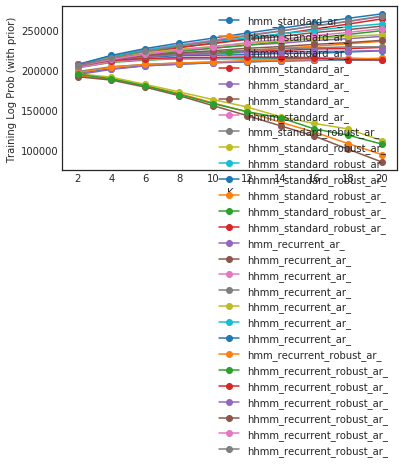

In [14]:
# Plot train and validation likelihoods
plt.figure(figsize=(6, 3))
for transitions in transitionss:
    for observations in observationss:
        hmm_results_prefix = "hmm_{}_{}_".format(transitions, observations)
        hmm_train_lls = [hmm_results[hmm_results_prefix + "K{}".format(K)][1][-1] for K in Ks]
        plt.plot(Ks, hmm_train_lls, '-o', label=hmm_results_prefix)
        
        for eta in etas:
            hhmm_results_prefix = "hhmm_{}_{}_".format(transitions, observations)
            hhmm_train_lls = [hhmm_results[hhmm_results_prefix + "K{}_eta{:1.0e}".format(K, eta)][1][-1] for K in Ks]
            plt.plot(Ks, hhmm_train_lls, '-o', label=hhmm_results_prefix)
        
plt.xlabel("K")
plt.xticks(Ks)
plt.ylabel("Training Log Prob (with prior) ")
plt.legend()

/home/scott/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


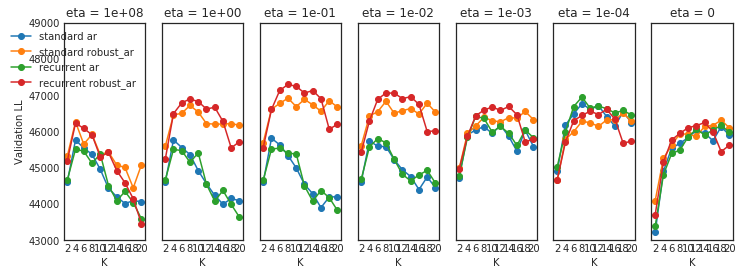

In [15]:
# Plot train and validation likelihoods

# num_bars = len(transitions) * len(observations)

plt.figure(figsize=(12, 4))
for transitions in transitionss:
    for observations in observationss:
        for i, eta in enumerate(etas):
            plt.subplot(1, 1 + len(etas), 1 + i)
            hhmm_results_prefix = "hhmm_{}_{}_".format(transitions, observations)
            hhmm_val_lls = [hhmm_results[hhmm_results_prefix + "K{}_eta{:1.0e}".format(K, eta)][2] for K in Ks]
            plt.plot(Ks, hhmm_val_lls, '-o', label=transitions + " " + observations)
            plt.title("eta = {:1.0e}".format(eta))

        plt.subplot(1, 1 + len(etas), len(etas) + 1)
        hmm_results_prefix = "hmm_{}_{}_".format(transitions, observations)
        hmm_val_lls = [hmm_results[hmm_results_prefix + "K{}".format(K)][2] for K in Ks]
        plt.plot(Ks, hmm_val_lls, '-o', label=transitions + " " + observations)
        plt.title("eta = 0")

for i in range(1 + len(etas)):
    plt.subplot(1, 1+len(etas), i+1)
    plt.xlabel("K")
    plt.xticks(Ks)
    plt.ylim(43000, 49000)
    if i == 0:
        plt.ylabel("Validation LL")
        plt.legend()
    else:
        plt.yticks([])
            

# Fit the HHMM to the full train and validation data

In [16]:
def _fit_to_all_data(model):
    lps = model.fit(train_xs + val_xs, tags=train_tags + val_tags, method="em", num_em_iters=100, initialize=False)
    return model, lps

In [17]:
# Fit the HMMs
best_results = {}

best_etas = {("standard", "ar") : 1e-4,
             ("standard", "robust_ar") : 1e-1,
             ("recurrent", "ar") : 1e-4,
             ("recurrent", "robust_ar") : 1e-1,}

for transitions in transitionss:
    for observations in observationss:
        hmm_results_prefix = "hmm_{}_{}".format(transitions, observations)
        hmm_val_lls = [hmm_results[hmm_results_prefix + "_K{}".format(K)][2] for K in Ks]
        best_K = Ks[np.argmax(hmm_val_lls)]
        
        # Fit the best model    
        results_name = "best_" + hmm_results_prefix
        print("Fitting ", results_name, " with K = ", best_K)
        fit = cached(results_dir, results_name)(_fit_to_all_data)
        hmm, _ = fit(hmm_results[hmm_results_prefix + "_K{}".format(best_K)][0])
        
        # Compute the log likelihood of the test data
        test_ll = hmm.log_likelihood(test_xs, tags=test_tags)
        best_results[results_name] = (hmm, test_ll)
        
# Fit the HHMMs
for transitions in transitionss:
    for observations in observationss:
        # Fit only with the best eta
        eta = best_etas[(transitions, observations)]
        
        hhmm_results_prefix = "hhmm_{}_{}".format(transitions, observations)
        hhmm_val_lls = [hhmm_results[hhmm_results_prefix + "_K{}_eta{:1.0e}".format(K, eta)][2] for K in Ks]
        best_K = Ks[np.argmax(hhmm_val_lls)]

        # Fit the best model    
        results_name = "best_" + hhmm_results_prefix
        print("Fitting ", results_name, " with K = ", best_K, " and eta = {:1.0e}".format(eta))
        fit = cached(results_dir, results_name)(_fit_to_all_data)
        hhmm, _ = fit(hhmm_results[hhmm_results_prefix + "_K{}_eta{:1.0e}".format(best_K, eta)][0])

        # Compute the log likelihood of the test data
        test_ll = hhmm.log_likelihood(test_xs, tags=test_tags)
        best_results[results_name] = (hhmm, test_ll)

with open(os.path.join(results_dir, "best_results.pkl"), "wb") as f:
    pickle.dump(best_results, f)

Fitting  best_hmm_standard_ar  with K =  18
Fitting  best_hmm_standard_robust_ar  with K =  18
Fitting  best_hmm_recurrent_ar  with K =  18
Fitting  best_hmm_recurrent_robust_ar  with K =  14
Fitting  best_hhmm_standard_ar  with K =  8  and eta = 1e-04
Fitting  best_hhmm_standard_robust_ar  with K =  8  and eta = 1e-01
Fitting  best_hhmm_recurrent_ar  with K =  8  and eta = 1e-04
Fitting  best_hhmm_recurrent_robust_ar  with K =  8  and eta = 1e-01


/home/scott/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


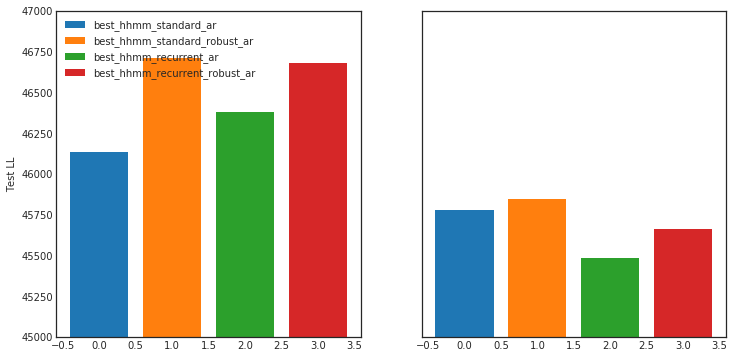

In [18]:
# Plot test likelihoods

plt.figure(figsize=(12, 6))
i = 0
for transitions in transitionss:
    for observations in observationss:
        plt.subplot(1, 2, 1)
        hhmm_results_prefix = "best_hhmm_{}_{}".format(transitions, observations)
        plt.bar(i, best_results[hhmm_results_prefix][1], label=hhmm_results_prefix)
        plt.ylim(45000, 47000)
        plt.ylabel("Test LL")
        
        plt.subplot(1, 2, 2)
        hmm_results_prefix = "best_hmm_{}_{}".format(transitions, observations)
        plt.bar(i, best_results[hmm_results_prefix][1], label=hmm_results_prefix)
        plt.ylim(45000, 47000)
        plt.yticks([])
        
        i += 1

plt.subplot(1, 2, 1)
plt.legend()

# Simulate from the model

In [19]:
def simulate_model(name, model, pad=3, N_smpls=20):
    # Get the inferred states
    z_infs = [model.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
    model.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
    z_infs = [model.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
    
    # Lower the noise
    model_low_noise = copy.deepcopy(model)
    model_low_noise.observations.inv_sigmas -= 4
    
    simulations = []

    for w in range(W):
        # Simulate N_smpls for this worm
        model_simulations_w = []
        for s in range(N_smpls):
            print("Model ", name, " Worm ", w, " sample ", s)
            # Sample data
            Tsmpl = Ts[w]
            zpre, xpre = z_infs[w][-pad:], xs[w][-pad:]
            zsmpl, xsmpl = model_low_noise.sample(Tsmpl, prefix=(zpre, xpre), tag=w, with_noise=True)

            zsmpl = np.concatenate((zpre, zsmpl))
            xsmpl = np.concatenate((xpre, xsmpl))

            # Truncate to stable region
            unstable = np.arange(Tsmpl+pad)[np.any(abs(xsmpl) > 5, axis=1)]
            T_stable = np.min(np.concatenate(([Tsmpl+pad], unstable)))
            zsmpl = zsmpl[:T_stable]
            xsmpl = xsmpl[:T_stable]

            # Project into neural space
            ysmpl = xsmpl.dot(pca.components_) + pca.mean_

            # Append
            model_simulations_w.append((zsmpl, xsmpl, ysmpl))
            
        # Append this worm
        simulations.append(model_simulations_w)
        
    return simulations

In [20]:
simulations = {}
for name, (model, _) in best_results.items(): 
    print("Simulating ", name)
    _sim = cached(results_dir, name + "_sim")(simulate_model)
    simulations[name] = _sim(name, model)

Simulating  best_hmm_standard_ar
Model  best_hmm_standard_ar  Worm  0  sample  0
Model  best_hmm_standard_ar  Worm  0  sample  1
Model  best_hmm_standard_ar  Worm  0  sample  2
Model  best_hmm_standard_ar  Worm  0  sample  3
Model  best_hmm_standard_ar  Worm  0  sample  4
Model  best_hmm_standard_ar  Worm  0  sample  5
Model  best_hmm_standard_ar  Worm  0  sample  6
Model  best_hmm_standard_ar  Worm  0  sample  7
Model  best_hmm_standard_ar  Worm  0  sample  8
Model  best_hmm_standard_ar  Worm  0  sample  9
Model  best_hmm_standard_ar  Worm  0  sample  10
Model  best_hmm_standard_ar  Worm  0  sample  11
Model  best_hmm_standard_ar  Worm  0  sample  12
Model  best_hmm_standard_ar  Worm  0  sample  13
Model  best_hmm_standard_ar  Worm  0  sample  14
Model  best_hmm_standard_ar  Worm  0  sample  15
Model  best_hmm_standard_ar  Worm  0  sample  16
Model  best_hmm_standard_ar  Worm  0  sample  17
Model  best_hmm_standard_ar  Worm  0  sample  18
Model  best_hmm_standard_ar  Worm  0  sample  

Model  best_hmm_standard_robust_ar  Worm  2  sample  19
Model  best_hmm_standard_robust_ar  Worm  3  sample  0
Model  best_hmm_standard_robust_ar  Worm  3  sample  1
Model  best_hmm_standard_robust_ar  Worm  3  sample  2
Model  best_hmm_standard_robust_ar  Worm  3  sample  3
Model  best_hmm_standard_robust_ar  Worm  3  sample  4
Model  best_hmm_standard_robust_ar  Worm  3  sample  5
Model  best_hmm_standard_robust_ar  Worm  3  sample  6
Model  best_hmm_standard_robust_ar  Worm  3  sample  7
Model  best_hmm_standard_robust_ar  Worm  3  sample  8
Model  best_hmm_standard_robust_ar  Worm  3  sample  9
Model  best_hmm_standard_robust_ar  Worm  3  sample  10
Model  best_hmm_standard_robust_ar  Worm  3  sample  11
Model  best_hmm_standard_robust_ar  Worm  3  sample  12
Model  best_hmm_standard_robust_ar  Worm  3  sample  13
Model  best_hmm_standard_robust_ar  Worm  3  sample  14
Model  best_hmm_standard_robust_ar  Worm  3  sample  15
Model  best_hmm_standard_robust_ar  Worm  3  sample  16
Mo

Model  best_hmm_recurrent_robust_ar  Worm  0  sample  16
Model  best_hmm_recurrent_robust_ar  Worm  0  sample  17
Model  best_hmm_recurrent_robust_ar  Worm  0  sample  18
Model  best_hmm_recurrent_robust_ar  Worm  0  sample  19
Model  best_hmm_recurrent_robust_ar  Worm  1  sample  0
Model  best_hmm_recurrent_robust_ar  Worm  1  sample  1
Model  best_hmm_recurrent_robust_ar  Worm  1  sample  2
Model  best_hmm_recurrent_robust_ar  Worm  1  sample  3
Model  best_hmm_recurrent_robust_ar  Worm  1  sample  4
Model  best_hmm_recurrent_robust_ar  Worm  1  sample  5
Model  best_hmm_recurrent_robust_ar  Worm  1  sample  6
Model  best_hmm_recurrent_robust_ar  Worm  1  sample  7
Model  best_hmm_recurrent_robust_ar  Worm  1  sample  8
Model  best_hmm_recurrent_robust_ar  Worm  1  sample  9
Model  best_hmm_recurrent_robust_ar  Worm  1  sample  10
Model  best_hmm_recurrent_robust_ar  Worm  1  sample  11
Model  best_hmm_recurrent_robust_ar  Worm  1  sample  12
Model  best_hmm_recurrent_robust_ar  Worm

Model  best_hhmm_standard_ar  Worm  3  sample  9
Model  best_hhmm_standard_ar  Worm  3  sample  10
Model  best_hhmm_standard_ar  Worm  3  sample  11
Model  best_hhmm_standard_ar  Worm  3  sample  12
Model  best_hhmm_standard_ar  Worm  3  sample  13
Model  best_hhmm_standard_ar  Worm  3  sample  14
Model  best_hhmm_standard_ar  Worm  3  sample  15
Model  best_hhmm_standard_ar  Worm  3  sample  16
Model  best_hhmm_standard_ar  Worm  3  sample  17
Model  best_hhmm_standard_ar  Worm  3  sample  18
Model  best_hhmm_standard_ar  Worm  3  sample  19
Model  best_hhmm_standard_ar  Worm  4  sample  0
Model  best_hhmm_standard_ar  Worm  4  sample  1
Model  best_hhmm_standard_ar  Worm  4  sample  2
Model  best_hhmm_standard_ar  Worm  4  sample  3
Model  best_hhmm_standard_ar  Worm  4  sample  4
Model  best_hhmm_standard_ar  Worm  4  sample  5
Model  best_hhmm_standard_ar  Worm  4  sample  6
Model  best_hhmm_standard_ar  Worm  4  sample  7
Model  best_hhmm_standard_ar  Worm  4  sample  8
Model  bes

Model  best_hhmm_recurrent_ar  Worm  0  sample  19
Model  best_hhmm_recurrent_ar  Worm  1  sample  0
Model  best_hhmm_recurrent_ar  Worm  1  sample  1
Model  best_hhmm_recurrent_ar  Worm  1  sample  2
Model  best_hhmm_recurrent_ar  Worm  1  sample  3
Model  best_hhmm_recurrent_ar  Worm  1  sample  4
Model  best_hhmm_recurrent_ar  Worm  1  sample  5
Model  best_hhmm_recurrent_ar  Worm  1  sample  6
Model  best_hhmm_recurrent_ar  Worm  1  sample  7
Model  best_hhmm_recurrent_ar  Worm  1  sample  8
Model  best_hhmm_recurrent_ar  Worm  1  sample  9
Model  best_hhmm_recurrent_ar  Worm  1  sample  10
Model  best_hhmm_recurrent_ar  Worm  1  sample  11
Model  best_hhmm_recurrent_ar  Worm  1  sample  12
Model  best_hhmm_recurrent_ar  Worm  1  sample  13
Model  best_hhmm_recurrent_ar  Worm  1  sample  14
Model  best_hhmm_recurrent_ar  Worm  1  sample  15
Model  best_hhmm_recurrent_ar  Worm  1  sample  16
Model  best_hhmm_recurrent_ar  Worm  1  sample  17
Model  best_hhmm_recurrent_ar  Worm  1  s

Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  11
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  12
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  13
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  14
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  15
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  16
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  17
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  18
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  19
Model  best_hhmm_recurrent_robust_ar  Worm  4  sample  0
Model  best_hhmm_recurrent_robust_ar  Worm  4  sample  1
Model  best_hhmm_recurrent_robust_ar  Worm  4  sample  2
Model  best_hhmm_recurrent_robust_ar  Worm  4  sample  3
Model  best_hhmm_recurrent_robust_ar  Worm  4  sample  4
Model  best_hhmm_recurrent_robust_ar  Worm  4  sample  5
Model  best_hhmm_recurrent_robust_ar  Worm  4  sample  6
Model  best_hhmm_recurrent_robust_ar  Worm  4  sample  7
Model  best_hhmm_recur